#### Step 1: Importing Libraries

In [1]:
!pip install ta
!pip install yfinance
# !pip install pydot graphviz

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=f218b08c2d74e57fb272712dc6e81437567587b37d578a9c1c56a7c94f860bf0
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from google.colab import output
import ta
from ta.volatility import BollingerBands
from ta.trend import MACD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from datetime import datetime

#### Step 2.1: Data Collection and Preprocessing

In [4]:
def gather_data(stock, start_date, end_date):
    data = yf.download(stock, start=start_date, end=end_date)
    return data

def import_options_data(ticker, expiration_date, period='1mo', interval='1d'):
    stock = yf.Ticker(ticker)
    historical_data = stock.history(period=period, interval=interval)
    options_chain = stock.option_chain(expiration_date)
    calls = options_chain.calls
    puts = options_chain.puts

    data = {
        'historical_data': historical_data,
        'calls': calls,
        'puts': puts
    }
    return data

def preprocess_data(data):
    data = data.fillna(method='ffill')
    return data

def preprocess_options_data(options_data):
    options_data = options_data.fillna(method='ffill')
    return options_data

def preprocess_historical_data(historical_data):
    historical_data = historical_data.fillna(method='ffill')
    return historical_data

def preprocess_volune(volume):
    return volume.fillna(method='ffill')

def calculate_volatility(data):
    data['Returns'] = data['Close'].pct_change()
    data['Historical_Volatility'] = data['Returns'].rolling(window=20).std() * np.sqrt(252)
    return data

stock = 'AAPL'
start_date = '2019-01-01'
end_date = '2024-05-25'
expiration_date = '2024-05-31'

data = gather_data(stock, start_date, end_date)
options_data = import_options_data(stock, expiration_date)
calls_data = options_data['calls']
puts_data = options_data['puts']

calls_implied_volatility = calls_data['impliedVolatility']
puts_implied_volatility = puts_data['impliedVolatility']
data.reset_index(inplace=True)

timestamps = data['Date']
calls_implied_volatility['Timestamp'] = timestamps.values
puts_implied_volatility['Timestamp'] = timestamps.values

calls_implied_volatility.drop(columns=['Date'], inplace=True)
puts_implied_volatility.drop(columns=['Date'], inplace=True)

calls_implied_volatility.index = timestamps[:len(calls_implied_volatility)]
puts_implied_volatility.index = timestamps[:len(puts_implied_volatility)]

#print(calls_implied_volatility)
#print(puts_implied_volatility)


data = data.merge(calls_implied_volatility, on = "Date", how='left')
data = data.merge(puts_implied_volatility, on = "Date", how='left', suffixes = ("_call", "_put"))

#print(data.head())

puts_data_bfill = puts_data.fillna(method='bfill')
calls_data_bfill = calls_data.fillna(method='bfill')

data = preprocess_data(data)
data = calculate_volatility(data)

# Reset indices of calls_data_bfill and puts_data_bfill to ensure proper alignment
#calls_data_bfill.reset_index(drop=True, inplace=True)
#puts_data_bfill.reset_index(drop=True, inplace=True)
#calls_data_bfill = calls_data_bfill.reset_index()
#calls_data_bfill = puts_data_bfill.reset_index()

#data = data.merge(calls_data_bfill[['impliedVolatility']], how='left', left_index=True, right_index=True)
#data = data.merge(puts_data_bfill[['impliedVolatility']], how='left', left_index=True, right_index=True, suffixes=('_call', '_put'))

# Fill NaN values in the impliedVolatility columns
data['impliedVolatility_call'].fillna(method='ffill', inplace=True)
data['impliedVolatility_put'].fillna(method='ffill', inplace=True)

# data['impliedVolatility'] = data['impliedVolatility_call'].combine_first(data['impliedVolatility_put'])
# data.drop(columns=['impliedVolatility_call', 'impliedVolatility_put'], inplace=True)

data['Short_MA'] = data['Close'].rolling(window=12).mean()
data['Long_MA'] = data['Close'].rolling(window=26).mean()
data.fillna(method='bfill', inplace=True)
puts_data_bfill = puts_data.fillna(method='bfill')
calls_data_bfill = calls_data.fillna(method='bfill')

data['impliedVolatility_call'] = pd.to_numeric(data['impliedVolatility_call'], errors='coerce')
data['impliedVolatility_put'] = pd.to_numeric(data['impliedVolatility_put'], errors='coerce')

# print(calls_data_bfill.index)
#print(data.columns)
print("\nOptions Chain (Calls and Puts) for stock ticker {} with expiration date {}:".format(stock, expiration_date))
print(f"Calls options data: \n{calls_data_bfill.head()}")
print(f"Puts options data: \n{puts_data_bfill.head()}")
print(data.head())

# Merging impliedVolatility column into data DataFrame
# data = pd.merge(data, calls_data_bfill[['Date', 'strike', 'impliedVolatility']], how='left', on=['lastTradeDate', 'strike'], suffixes=('', '_call'))

[*********************100%%**********************]  1 of 1 completed



Options Chain (Calls and Puts) for stock ticker AAPL with expiration date 2024-05-31:
Calls options data: 
        contractSymbol             lastTradeDate  strike  lastPrice    bid  \
0  AAPL240531C00100000 2024-05-24 17:50:39+00:00   100.0      90.25  89.75   
1  AAPL240531C00120000 2024-05-07 16:18:54+00:00   120.0      61.75  69.70   
2  AAPL240531C00130000 2024-05-24 18:31:09+00:00   130.0      60.27  59.70   
3  AAPL240531C00135000 2024-05-23 19:58:24+00:00   135.0      51.55  54.70   
4  AAPL240531C00140000 2024-05-24 17:30:05+00:00   140.0      50.33  49.75   

     ask    change  percentChange  volume  openInterest  impliedVolatility  \
0  90.35  8.400002      10.262678     7.0            10           1.851563   
1  70.35  0.000000       0.000000     1.0             3           1.296879   
2  60.60  0.000000       0.000000     2.0            32           1.291019   
3  55.50  0.000000       0.000000     3.0             5           1.119145   
4  50.40 -1.349999      -2.612226

<ipython-input-4-c4a597d2c072>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_implied_volatility['Timestamp'] = timestamps.values
<ipython-input-4-c4a597d2c072>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  puts_implied_volatility['Timestamp'] = timestamps.values


#### Step 2.2: Plotting Function to check any Noise or Outliers

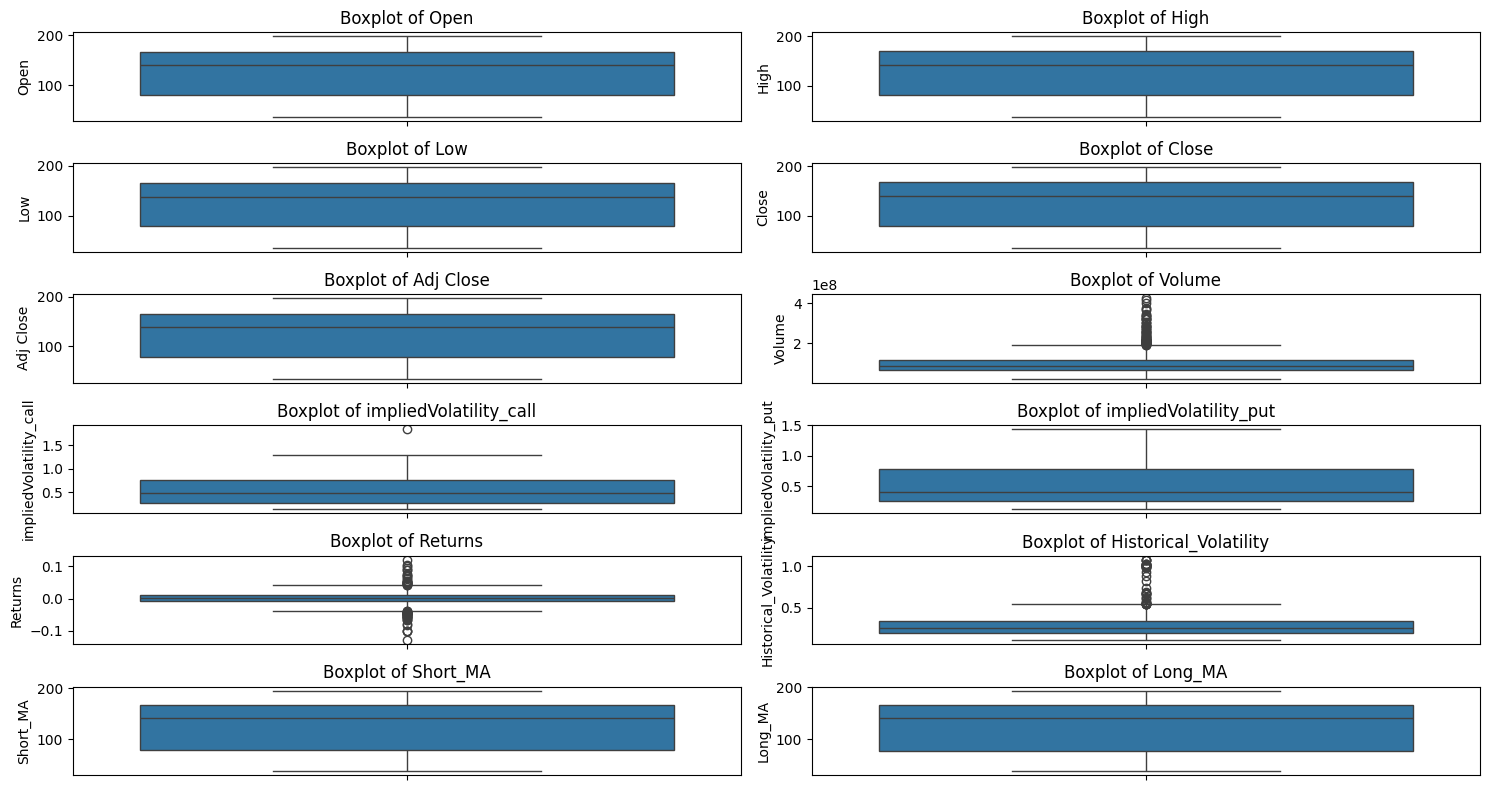

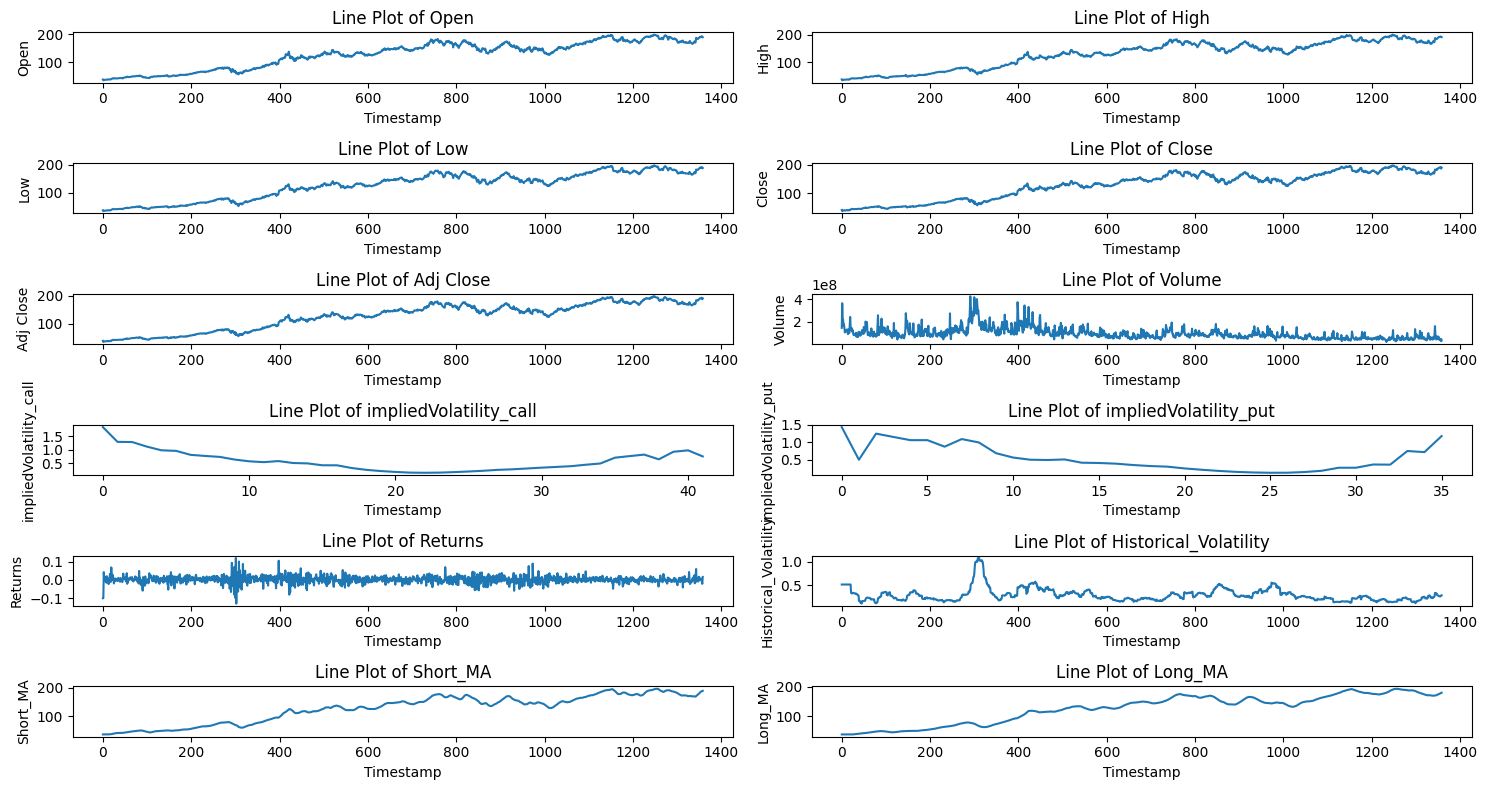

In [5]:
def plot_data_distribution(data):
    numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
    num_cols = len(numerical_cols)
    num_rows = (num_cols + 1) // 2

    plt.figure(figsize=(15, 8))
    for i, col in enumerate(numerical_cols, start=1):
        plt.subplot(num_rows, 2, i)
        sns.boxplot(data[col])
        plt.title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 8))
    for i, col in enumerate(numerical_cols, start=1):
        plt.subplot(num_rows, 2, i)
        plt.plot(data.index, data[col])
        plt.title(f'Line Plot of {col}')
        plt.xlabel('Timestamp')
        plt.ylabel(col)

    plt.tight_layout()
    plt.show()

plot_data_distribution(data)

#### Step 3: Model Evaluation & Training

In [6]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Historical_Volatility','impliedVolatility_call','impliedVolatility_put']
target = 'Close'

X = data[features]
y = data[target]

l1_value = 0.001  # Adjusted by trial & error
l2_value = 0.001  # Adjusted by trial & error

# Spliting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Creating ANN Model
def create_ann_model(input_shape):
    model = Sequential([
        Dense(32, input_shape=input_shape, activation='relu',
              kernel_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value),
              bias_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value)),
        Dense(32, activation='relu',
              kernel_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value),
              bias_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Creating RNN(LSTM) Model
def create_rnn_model(input_shape):
    model = Sequential([
        LSTM(50, input_shape=input_shape, activation='relu', return_sequences=True,
             kernel_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value),
             bias_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value)),
        LSTM(50, activation='relu',
             kernel_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value),
             bias_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

ann_model = create_ann_model((X_train.shape[1],))
rnn_model = create_rnn_model((X_train.shape[1], 1))

ann_optimizer = Adam(learning_rate=0.0001)
rnn_optimizer = Adam(learning_rate=0.0001)
ann_model.compile(optimizer=ann_optimizer, loss='mse')
rnn_model.compile(optimizer=rnn_optimizer, loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

ann_test_loss = ann_model.evaluate(X_test, y_test)
rnn_test_loss = rnn_model.evaluate(X_test.reshape(-1, X_test.shape[1], 1), y_test)

print(f"ANN test loss: {ann_test_loss}")
print(f"RNN test loss: {rnn_test_loss}")

ann_model.summary()
rnn_model.summary()

5/5 [==============================] - 0s 4ms/step - loss: nan
ANN test loss: nan
RNN test loss: nan
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1377 (5.38 KB)
Trainable params: 1377 (5.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (Non

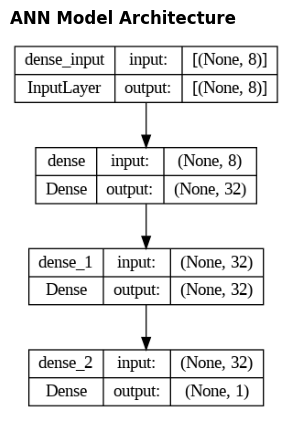

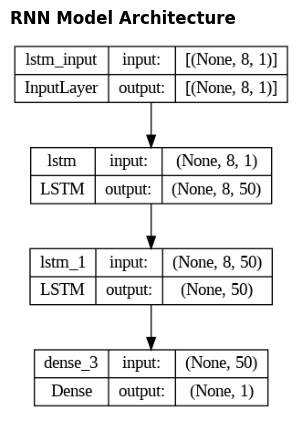

In [7]:
plot_model(ann_model, to_file='ann_model.png', show_shapes=True, show_layer_names=True)
plt.imshow(plt.imread('ann_model.png'))
plt.text(0, -20, "ANN Model Architecture", fontsize=12, color='black', weight='bold')
plt.axis('off')
plt.show()

plot_model(rnn_model, to_file='rnn_model.png', show_shapes=True, show_layer_names=True)
plt.imshow(plt.imread('rnn_model.png'))
plt.text(0, -20, "RNN Model Architecture", fontsize=12, color='black', weight='bold')
plt.axis('off')
plt.show()

#### Step 4: Model Testing

In [8]:
X_train_np = X_train
X_test_np = X_test
X_val_np = X_val
y_val_np = y_val.values

X_train_np = np.nan_to_num(X_train_np)
X_test_np = np.nan_to_num(X_test_np)
X_val_np = np.nan_to_num(X_val_np)

y_train_np = np.nan_to_num(y_train)
y_test_np = np.nan_to_num(y_test)

print(f"Shape of X_train_np before reshape: {X_train_np.shape}")
print(f"Shape of X_test_np before reshape: {X_test_np.shape}")

# Reshaping
X_train_rnn = X_train_np.reshape((X_train_np.shape[0], X_train_np.shape[1], 1))
X_test_rnn = X_test_np.reshape((X_test_np.shape[0], X_test_np.shape[1], 1))
X_val_rnn = X_val_np.reshape((X_val_np.shape[0], X_val_np.shape[1], 1))

print(f"Shape of X_train_rnn: {X_train_rnn.shape}")
print(f"Shape of X_test_rnn: {X_test_rnn.shape}")
print(f"Shape of X_val_rnn: {X_val_rnn.shape}")

Shape of X_train_np before reshape: (1087, 8)
Shape of X_test_np before reshape: (136, 8)
Shape of X_train_rnn: (1087, 8, 1)
Shape of X_test_rnn: (136, 8, 1)
Shape of X_val_rnn: (136, 8, 1)


#### Step 5.1: Training & Validation

In [9]:
history_ann = ann_model.fit(X_train_np, y_train_np, epochs=700, validation_data=(X_test_np, y_test_np), callbacks=[early_stopping, reduce_lr])
history_rnn = rnn_model.fit(X_train_rnn, y_train_np, epochs=200, validation_data=(X_test_rnn, y_test_np), callbacks=[early_stopping, reduce_lr])

predictions_ann = ann_model.predict(X_val_np).ravel()
predictions_df_ann = pd.DataFrame(predictions_ann, index=data.index[:len(predictions_ann)], columns=['ann_prediction'])

predictions_rnn = rnn_model.predict(X_val_rnn).ravel()
predictions_df_rnn = pd.DataFrame(predictions_rnn, index=data.index[:len(predictions_rnn)], columns=['rnn_prediction'])

mae_ann = mean_absolute_error(y_val_np, predictions_ann)
rmse_ann = np.sqrt(mean_squared_error(y_val_np, predictions_ann))
print("ANN Metrics:")
print(f"Mean Absolute Error (MAE): {mae_ann:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ann:.2f}")

mae_rnn = mean_absolute_error(y_val_np, predictions_rnn)
rmse_rnn = np.sqrt(mean_squared_error(y_val_np, predictions_rnn))
print("RNN Metrics:")
print(f"Mean Absolute Error (MAE): {mae_rnn:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rnn:.2f}")

train_loss_ann = history_ann.history['loss']
val_loss_ann = history_ann.history.get('val_loss', None)
train_accuracy_ann = history_ann.history.get('accuracy', None)
val_accuracy_ann = history_ann.history.get('val_accuracy', None)

train_loss_rnn = history_rnn.history['loss']
val_loss_rnn = history_rnn.history.get('val_loss', None)
train_accuracy_rnn = history_rnn.history.get('accuracy', None)
val_accuracy_rnn = history_rnn.history.get('val_accuracy', None)

Epoch 1/700
34/34 [==============================] - 3s 29ms/step - loss: 18335.7617 - val_loss: 19659.0996 - lr: 1.0000e-04
Epoch 2/700
34/34 [==============================] - 0s 8ms/step - loss: 18297.3496 - val_loss: 19614.8574 - lr: 1.0000e-04
Epoch 3/700
34/34 [==============================] - 0s 11ms/step - loss: 18257.6660 - val_loss: 19569.6484 - lr: 1.0000e-04
Epoch 4/700
34/34 [==============================] - 0s 7ms/step - loss: 18217.2852 - val_loss: 19523.2734 - lr: 1.0000e-04
Epoch 5/700
34/34 [==============================] - 0s 6ms/step - loss: 18175.7930 - val_loss: 19475.4844 - lr: 1.0000e-04
Epoch 6/700
34/34 [==============================] - 0s 6ms/step - loss: 18130.9277 - val_loss: 19419.3887 - lr: 1.0000e-04
Epoch 7/700
34/34 [==============================] - 0s 8ms/step - loss: 18077.5820 - val_loss: 19353.7402 - lr: 1.0000e-04
Epoch 8/700
34/34 [==============================] - 0s 5ms/step - loss: 18015.9199 - val_loss: 19279.0117 - lr: 1.0000e-04
Epoch 

In [10]:
print(predictions_df_ann)
print(predictions_df_rnn)

     ann_prediction
0         49.510921
1        143.717667
2        169.697876
3        171.233459
4        127.139458
..              ...
131      182.893188
132       55.170910
133       80.416328
134      140.969391
135      131.219040

[136 rows x 1 columns]
     rnn_prediction
0         51.298164
1        142.985443
2        168.414474
3        170.059387
4        125.852432
..              ...
131      183.709305
132       56.441105
133       80.756104
134      140.210861
135      131.400803

[136 rows x 1 columns]


#### Step 5.2: Plotting Learning Curve to check for Bias & Varience

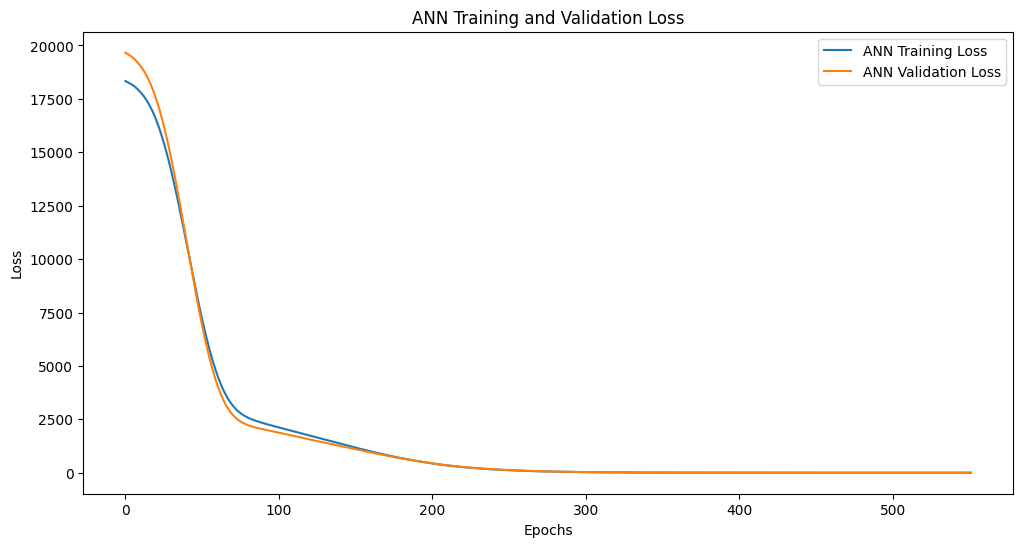

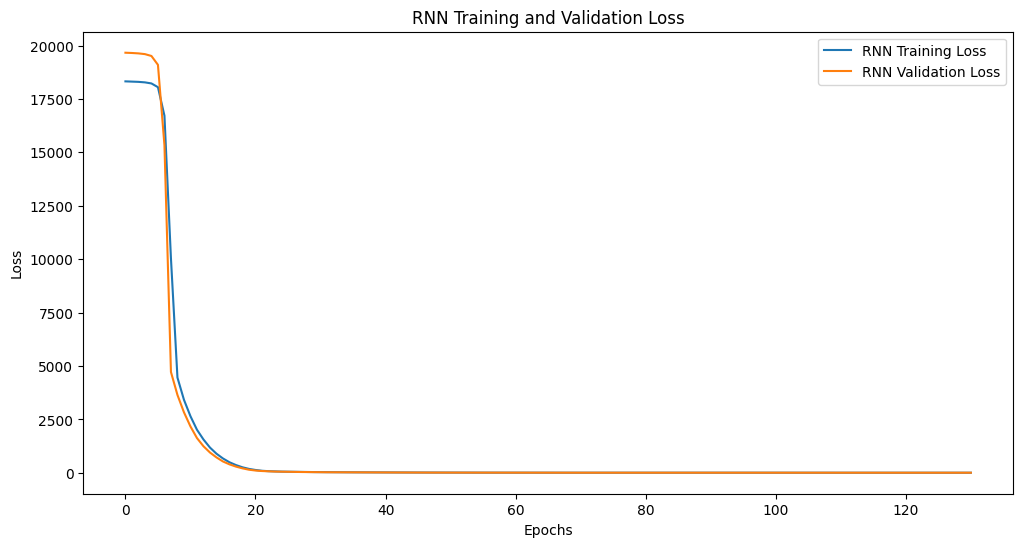

Shape of ANN predictions: (136,)
Shape of RNN predictions: (136,)
Shape of reshaped ANN predictions: (136,)
Shape of reshaped RNN predictions: (136,)
Shape of y_val: (136,)


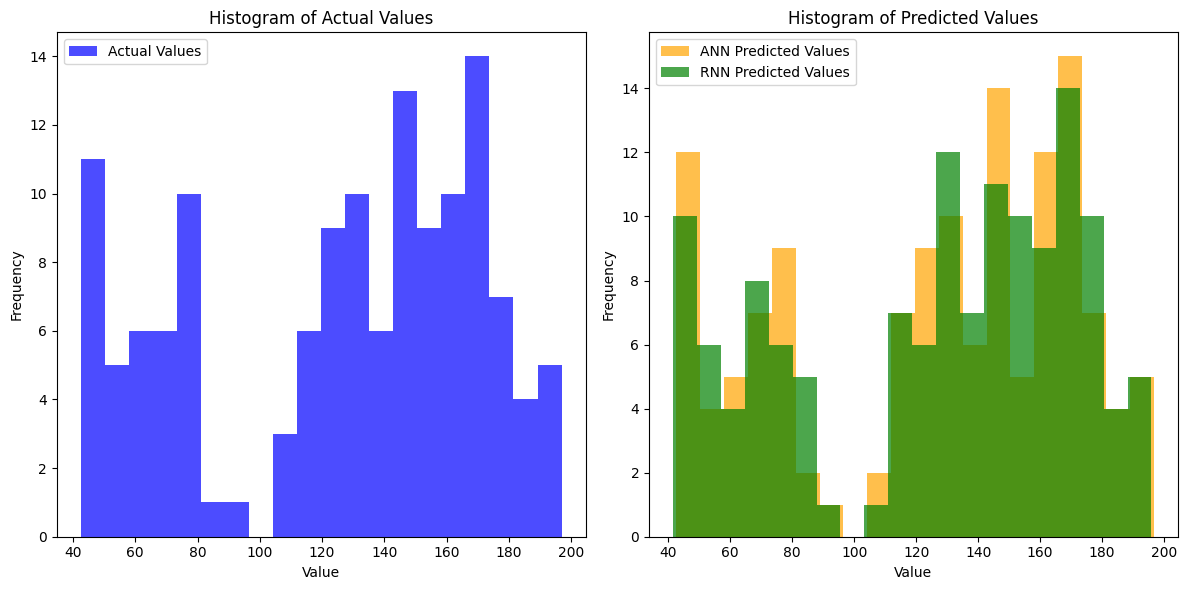

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss_ann, label='ANN Training Loss')
if val_loss_ann is not None:
    plt.plot(val_loss_ann, label='ANN Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ANN Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_loss_rnn, label='RNN Training Loss')
if val_loss_rnn is not None:
    plt.plot(val_loss_rnn, label='RNN Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Training and Validation Loss')
plt.legend()
plt.show()

reshaped_predictions_ann = predictions_ann.ravel()
reshaped_predictions_rnn = predictions_rnn.ravel()

print(f"Shape of ANN predictions: {predictions_ann.shape}")
print(f"Shape of RNN predictions: {predictions_rnn.shape}")
print(f"Shape of reshaped ANN predictions: {reshaped_predictions_ann.shape}")
print(f"Shape of reshaped RNN predictions: {reshaped_predictions_rnn.shape}")
print(f"Shape of y_val: {y_val_np.shape}")

def plot_histograms(y_val, predictions_ann, predictions_rnn, bins=20):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(y_val, bins=bins, alpha=0.7, color='blue', label='Actual Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Actual Values')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(predictions_ann, bins=bins, alpha=0.7, color='orange', label='ANN Predicted Values')
    plt.hist(predictions_rnn, bins=bins, alpha=0.7, color='green', label='RNN Predicted Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Values')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_histograms(y_val_np, reshaped_predictions_ann, reshaped_predictions_rnn, bins=20)

#### Step 6: Strategy Selection and Integration

In [ ]:
nan_indices = data[features]['impliedVolatility_call'].isna()
print(nan_indices.sum())

1305


In [ ]:
# Replace NaN values in the "impliedVolatility" column with 0
# data.loc[:, ('impliedVolatility',)] = np.nan_to_num(data.loc[:, ('impliedVolatility',)], nan=0)

In [ ]:
print(data[features].head())
print(data[features].shape)
data[features].info()
print(data[features].describe())

        Open       High        Low      Close     Volume  \
0  38.722500  39.712502  38.557499  39.480000  148158800   
1  35.994999  36.430000  35.500000  35.547501  365248800   
2  36.132500  37.137501  35.950001  37.064999  234428400   
3  37.174999  37.207500  36.474998  36.982498  219111200   
4  37.389999  37.955002  37.130001  37.687500  164101200   

   Historical_Volatility  impliedVolatility_call  impliedVolatility_put  
0               0.512113                1.871094               1.312503  
1               0.512113                1.734376               1.187504  
2               0.512113                1.605471               1.093755  
3               0.512113                1.414065               1.031255  
4               0.512113                0.890626               0.937501  
(1343, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343 entries, 0 to 1342
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------               

43/43 [==============================] - 0s 3ms/step


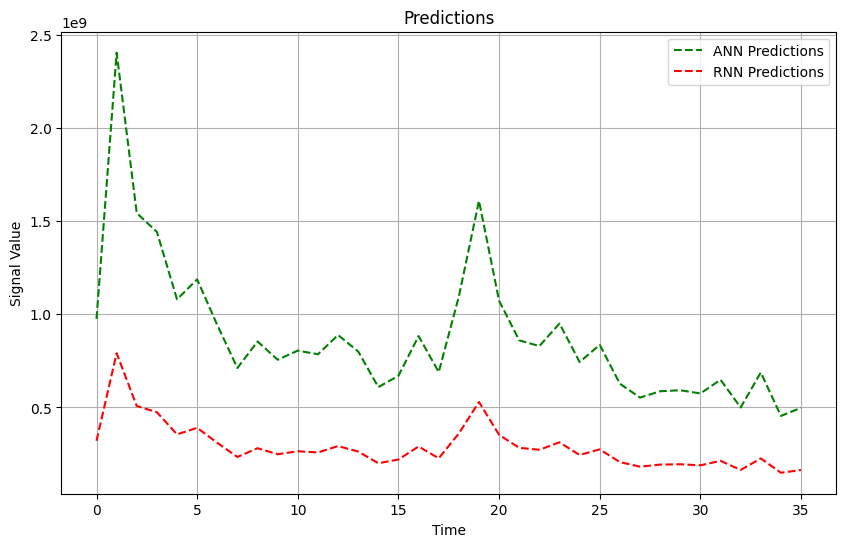

43/43 [==============================] - 0s 3ms/step
0       Buy Call
1       Buy Call
2       Buy Call
3       Buy Call
4       Buy Call
          ...   
1354    Buy Call
1355    Buy Call
1356    Buy Call
1357    Buy Call
1358    Buy Call
Name: call_put_signal, Length: 1359, dtype: object


In [12]:
def generate_options_signals(data, ann_model, rnn_model, features):
    # Predicting ANN and RNN signals
    data['ann_signal'] = ann_model.predict(data[features])
    data['rnn_signal'] = rnn_model.predict(data[features])

    # Calculating MACD
    data['ema12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['ema26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['macd'] = data['ema12'] - data['ema26']
    data['macd_signal'] = data['macd'].ewm(span=9, adjust=False).mean()
    data['macd_hist'] = data['macd'] - data['macd_signal']

    window = 20
    data['rolling_mean'] = data['Close'].rolling(window=window).mean()
    data['rolling_std'] = data['Close'].rolling(window=window).std()
    data['upper_band'] = data['rolling_mean'] + 2 * data['rolling_std']
    data['lower_band'] = data['rolling_mean'] - 2 * data['rolling_std']

    data['buying_call'] = (data['ann_signal'] > 0) | (data['rnn_signal'] > 0) | (data['macd'] > data['macd_signal']) | (data['Close'] > data['upper_band'])
    data['call_put_signal'] = np.where(
        data['buying_call'],
        'Buy Call',
        np.where(
            (data['ann_signal'] < 0) | (data['rnn_signal'] < 0) | (data['macd'] < data['macd_signal']) | (data['Close'] < data['lower_band']),
            'Buy Put',
            np.where(
                (data['ann_signal'] > 0) & (data['rnn_signal'] < 0) & (data['macd'] > data['macd_signal']),
                'Sell Call',  # Selling of Call when buying Put
                np.where(
                    (data['ann_signal'] < 0) & (data['rnn_signal'] > 0) & (data['macd'] < data['macd_signal']),
                    'Sell Put',  # Selling of Put when buying Call
                    'No Signal'
                )
            )
        )
    )
    return data

def visualize_predictions(data):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['ann_signal'], label='ANN Predictions', linestyle='--', color='green')
    plt.plot(data.index, data['rnn_signal'], label='RNN Predictions', linestyle='--', color='red')
    plt.xlabel('Time')
    plt.ylabel('Signal Value')
    plt.title('Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()


data_with_signals = generate_options_signals(data.copy(), ann_model, rnn_model, features)
visualize_predictions(data_with_signals)

data_with_signals = generate_options_signals(data, ann_model, rnn_model, features)
print(data_with_signals['call_put_signal'])

In [ ]:
signal_counts = data['call_put_signal'].value_counts()

print("Signal Counts:")
print(signal_counts)

Signal Counts:
call_put_signal
Buy Call    703
Buy Put     640
Name: count, dtype: int64


#### Step 7: Plotting the stock data with entry and exit points

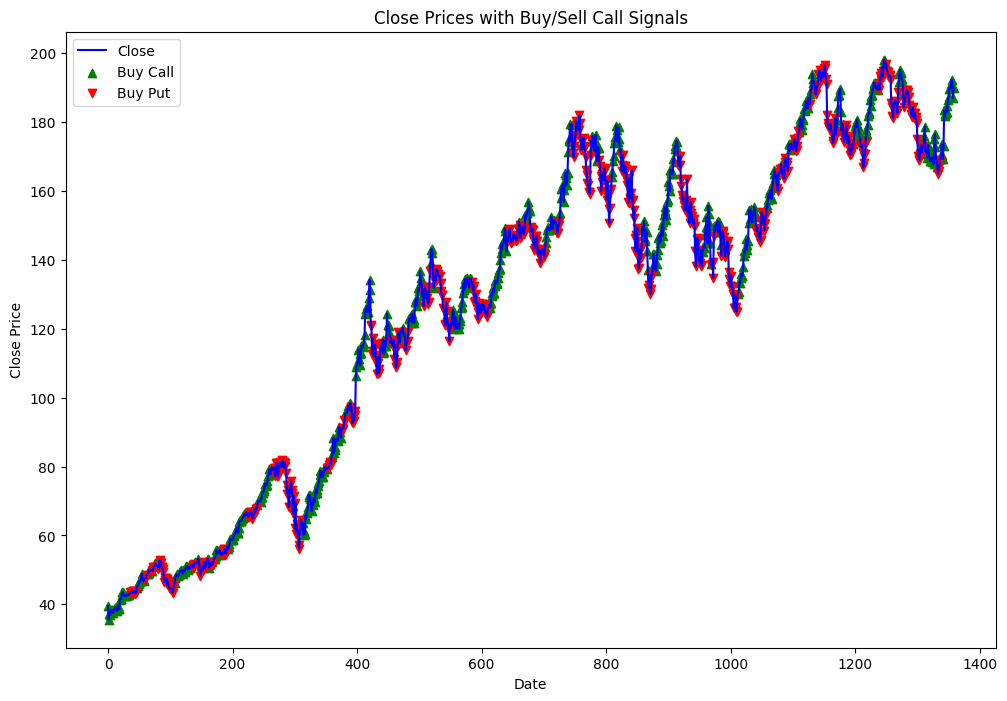

In [13]:
def plot_options_signals_call(data):
    plt.figure(figsize=(12, 8))
    plt.plot(data.index, data['Close'], label='Close', color='blue')
    buy_call_signals = data[data['call_put_signal'] == 'Buy Call']
    buy_put_signals = data[data['call_put_signal'] == 'Buy Put']
    plt.scatter(buy_call_signals.index, buy_call_signals['Close'], marker='^', color='green', label='Buy Call', alpha=1)
    plt.scatter(buy_put_signals.index, buy_put_signals['Close'], marker='v', color='red', label='Buy Put', alpha=1)

    #plt.figure(figsize=(12, 8))
    #plt.plot(data.index, data['Close'], label='Close', color='blue')
    #buy_call_signals = data[data['call_put_signal'] == 'Buy Call']
    #buy_put_signals = data[data['call_put_signal'] == 'Buy Put']
    #plt.scatter(buy_put_signals.index, buy_put_signals['Close'], marker='^', color='red', label='Sell Call', alpha=1)
    #plt.scatter(buy_call_signals.index, buy_call_signals['Close'], marker='v', color='green', label='Sell Put', alpha=1)

    plt.title('Close Prices with Buy/Sell Call Signals')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

plot_options_signals_call(data)

#### Step 8: Testing and Simulation

In [14]:
def simulate_options_trading(data, initial_balance=10000):
    balance = initial_balance
    positions = 0

    for index, row in data.iterrows():
        if row['call_put_signal'] == 'Buy Call':
            positions -= 1
            balance += row['Close']

        elif row['call_put_signal'] == 'Buy Put':
            positions -= 1
            balance += row['Close']

        elif row['call_put_signal'] == 'Sell Call':
            positions += 1
            balance -= row['Close']

        elif row['call_put_signal'] == 'Sell Put':
            positions += 1
            balance -= row['Close']

    final_profit = balance - initial_balance
    return final_profit

final_profit = simulate_options_trading(data_with_signals)
print(f"Final profit from simulated options trading: ${final_profit:.2f}")

Final profit from simulated options trading: $172930.52


In [ ]:
import tkinter as tk
from tkinter import ttk
from IPython.display import Image, display

# Function to update GUI with results
def update_results():
    # Plot signals on stock price chart
    plot_options_signals_call(data_with_signals)
    plt.savefig('signals.png')
    display(Image(filename='signals.png'))

    # Display ANN and RNN predictions
    visualize_predictions(data_with_signals)
    plt.savefig('predictions.png')
    display(Image(filename='predictions.png'))

    # Simulate options trading and calculate profit
    final_profit = simulate_options_trading(data_with_signals)
    label_profit.config(text=f"Final profit from simulated options trading: ${final_profit:.2f}")

# Create main window
root = tk.Tk()
root.title("Trading Bot Results")

# Create frame for results
frame = ttk.Frame(root)
frame.pack(padx=10, pady=10)

# Button to update results
button_update = ttk.Button(root, text="Update Results", command=update_results)
button_update.pack(pady=10)

# Label to display profit
label_profit = ttk.Label(root, text="")
label_profit.pack(pady=10)

# Run GUI
root.mainloop()

TclError: no display name and no $DISPLAY environment variable

#### Step 9: Live Trading

In [ ]:
pip install oandapyV20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69779 sha256=5cc5b86a0e51eca4eeb0a709d9a3786307f10106ce3a4bdeebba89df07186858
  Stored in directory: /root/.cache/pip/wheels/8e/69/ab/a6da84a85b9bf3b5a98ca15c6c52b7854f32b10c70fe0531a1
Successfully built oandapyV20


In [ ]:
import oandapyV20
import oandapyV20.endpoints.accounts as accounts
from oandapyV20.contrib.requests import MarketOrderRequest

account_id = '101-004-28318313-001'
api_key = 'c2143f3209c9e7cbdf7c5c9d2dd309c2-504124cce642dc607b6a5d462ec6f9b5'

api = oandapyV20.API(access_token=api_key, environment="practice")

r = accounts.AccountDetails(accountID=account_id)
response = api.request(r)

print("Account Details:")
print(response)

instrument = 'stock'
quantity = 1000  #

request = MarketOrderRequest(instrument=instrument, units=quantity)

# Execute the market order
r = oandapyV20.endpoints.orders.OrderCreate(accountID=account_id, data=request.data)
response = api.request(r)

# Print order response
print("Order Response:")
print(response)

Account Details:
{'account': {'guaranteedStopLossOrderMode': 'ALLOWED', 'hedgingEnabled': False, 'id': '101-004-28318313-001', 'createdTime': '2024-02-14T05:07:28.466714892Z', 'currency': 'GBP', 'createdByUserID': 28318313, 'alias': 'Primary', 'marginRate': '0.03333333333333', 'lastTransactionID': '3', 'balance': '100000.0000', 'openTradeCount': 0, 'openPositionCount': 0, 'pendingOrderCount': 0, 'pl': '0.0000', 'resettablePL': '0.0000', 'resettablePLTime': '0', 'financing': '0.0000', 'commission': '0.0000', 'dividendAdjustment': '0', 'guaranteedExecutionFees': '0.0000', 'orders': [], 'positions': [], 'trades': [], 'unrealizedPL': '0.0000', 'NAV': '100000.0000', 'marginUsed': '0.0000', 'marginAvailable': '100000.0000', 'positionValue': '0.0000', 'marginCloseoutUnrealizedPL': '0.0000', 'marginCloseoutNAV': '100000.0000', 'marginCloseoutMarginUsed': '0.0000', 'marginCloseoutPositionValue': '0.0000', 'marginCloseoutPercent': '0.00000', 'withdrawalLimit': '100000.0000', 'marginCallMarginUse

AttributeError: module 'oandapyV20.endpoints' has no attribute 'orders'

In [ ]:
!pip install oandapyV20
!pip install git+https://github.com/yhilpisch/tpqoa.git

In [ ]:
import tpqoa

api = tpqoa.tpqoa('/content/oanda.cfg')

In [ ]:
api.get_instruments()[:15]

In [ ]:
instrument = stock
start = start_date
end = end_date
granularity = 'M1'
price = 'M'

data = api.get_history(instrument,start,end,granularity, price)

data.info()

In [ ]:
data['returns'] = np.log(data['c'] / data['c'].shift(1))

cols = []
for momentum in [15,30,60,120]:
  col = 'position_{}'.format(momentum)
  data[col] = np.sign(data['returns'].rolling(momentum).mean())
  cols.append(col)

In [ ]:
from pylab import pyl
plt.style.use('seaborn')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'

strats = ['returns']

for col in cols:
  strat = 'strategy_{}'.format(col.split('_')[1])
  data[strat] = data[col].shift(1) * data['returns']
  strats.append(strat)

data[strats].dropna().cumsum().apply(np.exp).plot(figsize=(10,6))

In [ ]:
data[strats].dropna().cumsum().apply(
    lambda x: x * 20).apply(np.exp).plot(figsize=(10,6))

In [ ]:
instrument = 'EUR_USD'

api.stream_data(instrument, stop=10)

In [ ]:
api.create_order(instrument, 1000)
api.create_order(instrument, -1500)
api.create_order(instrument, 500)

In [ ]:
import tpqoa
import numpy as np
import pandas as pd

class MomentumTrader(tpqoa.tpqoa):
  def __init__(self, conf_file, instrument, bar_length, momentum, units, *args, **kwargs):
    super(MomentumTrader, self).__init__(conf_file)
    self.position = 0
    self.instrument = instrument
    self.momentum = momentum
    self.bar_length = bar_length
    self.units = units
    self.raw_data = pd.DataFrame()
    self.min_length = self.momentum + 1

  def on_success(self,time,bid, ask):
    '''Takes actions when new tick data arrives'''
    print(self.ticks, end=' ')
    self.raw_data = pd.concat([self.raw_data,pd.DataFrame(
        {'bid':bid, 'ask':ask}, index=[pd.Timestamp(time)])])
    self.data = self.raw_data.resample(
        self.bar_length, label='right').last().ffill().iloc[:-1]
    self.data['mid'] = self.data.mean(axis=1)
    self.data['returns'] = np.log(self.data['mid'] / self.data['mid'].shift(1))
    self.data['position'] = np.sign(self.data['returns'].rolling(self.momentum).mean())

    if len(self.data) > self.min_length:
      self.min_length += 1
      if self.data['position'].iloc[-1] == 1:
        if self.position == 0:
          self.create_order(self.instrument, self.units)
        elif self.position == -1:
          self.create_order(self.instrument, self.units * 2)
        self.position = 1
      elif self.data['position'].iloc[-1] == -1:
        if self.position == 0:
          self.create_order(self.instrument, -self.units)
        elif self.position == 1:
          self.create_order(self.instrument, -self.units * 2)
        self.position = -1

In [ ]:
mt = MomentumTrader('/content/drive/MyDrive/oanda.cfg',
                       instrument=instrument,
                       bar_length='10s',
                       momentum=6,
                       units=10000)

mt.stream_data(mt.instrument, stop=500)

In [ ]:
oo = mt.create_order(instrument, units=mt.position * mt.units, ret=True, suppress=True)

oo

In [ ]:
api.get_account_summary()

In [ ]:
api.get_transactions(tid=int(oo['id']) - 2)

In [ ]:
api.print_transactions(tid=int(oo['id']) - 18)

In [ ]:
import oandapyV20
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest

account_id = "abhishekhmalaviya@gmail.com"
access_token = "c2143f3209c9e7cbdf7c5c9d2dd309c2-504124cce642dc607b6a5d462ec6f9b5"
environment = "practice"